<div style="background-color:#e6f2ff; padding:20px; border-radius:10px;">
<img style="float:left; margin-right:20px;" src='Figures/alinco.png' width="120"/>
<h1 style="color:#000047;">Tarea 3: Algoritmos de detección de Outliers Multivariados (Uriel Juarez)</h1>
<br style="clear:both"/>
</div>


<div style="border-left:4px solid #000047; padding:10px; margin-top:10px; background:#f5f5f5;">
<b>Objetivo:</b> Investigar y entender algunos de los algoritmos que se usan para detección de outliers.
</div>

<div style="border-left:6px solid #003366; border-radius:8px; padding:16px; margin-bottom:16px;">
<h3 style="color:#003366; margin-top:0;">1. Local Outlier Factor (LOF) <span style='font-size:0.8em; color:#888;'>&#128200;</span></h3>
<p style="font-size:1.08em;">
El <b>Local Outlier Factor (LOF)</b> es un algoritmo no supervisado que detecta anomalías comparando la densidad local de cada punto con la de sus vecinos. Si la densidad de un punto es significativamente menor que la de sus vecinos, se considera un outlier.
</p>
<ul style="font-size:1.05em;">
<li>Consulta el artículo original: <a href="https://dl.acm.org/doi/pdf/10.1145/335191.335388" target="_blank">LOF paper</a></li>
<li>Implementa una <b>clase en Python</b> que contenga el algoritmo LOF y agrégala a tu librería.</li>
<li>Prueba tu implementación con el dataset <code>insurance.csv</code> que se encuentra en la carpeta de Data:</li>
  <ul>
    <li>Detecta los outliers usando tu clase.</li>
    <li>Compara los resultados con el modelo LOF de <code>sklearn</code>.</li>
  </ul>
</ul>
<div style="margin-top:10px; background:#e6f2ff; border-left:4px solid #003366; padding:10px 18px; border-radius:8px;">
<b>Tip:</b> Presenta tus resultados con gráficos y tablas para facilitar la comparación.
</div>
</div>

In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

class AlgorLOF:
    """
    Algoritmo LOF (Local Outlier Factor).

    Parámetros
    ----------
    n_neighbors : int
        Número de vecinos (k / MinPts).
    """

    def __init__(self, n_neighbors=20): #Valor por defecto 20
        self.n_neighbors = n_neighbors #Numero de vecinos por punto
        self.X_ = None          # datos
        self.lof_ = None        # LOF de cada punto
        self.lrd_ = None        # densidad local
        self.neighbors_ = None  # indices de vecinos

    def _pairwise_distances(self, X):
        """
        Calcula la matriz de distancias euclidianas entre todos los puntos.
        X: (n_muestras, n_features)
        return: (n_muestras, n_muestras)
        """
        X = np.asarray(X, dtype=float) #Aseguramos que X es un array numpy
        diff = X[:, np.newaxis, :] - X[np.newaxis, :, :] #Diferencia entre todos los puntos
        D = np.sqrt(np.sum(diff**2, axis=2)) #Calculo de la distancia euclidiana
        return D

    def fit(self, X):
        """
        Calcula el LOF para cada punto de X y guarda los resultados 

        X : array-like, shape (n_muestras, n_features)
        """
        X = np.asarray(X, dtype=float)
        n = X.shape[0]
        self.X_ = X

        # Aseguramos que k < n
        k = min(self.n_neighbors, n - 1)

        # Matriz de distancias
        D = self._pairwise_distances(X)

        # Vecinos mas cercanos (ordena distancias por fila)
        idx_sorted = np.argsort(D, axis=1)

        # Primer indice es el propio punto, tomamos los siguientes k
        neighbors_idx = idx_sorted[:, 1:k+1]
        self.neighbors_ = neighbors_idx

        # k-distance(p): distancia al k-esimo vecino
        k_distance = D[np.arange(n), neighbors_idx[:, -1]]

        # Reach - dist_k(p, o) = max(k-distance(o), d(p,o)) (se usa reachability distance)
        reach_dist = np.zeros((n, k))
        for i in range(n):
            for j in range(k):
                o = neighbors_idx[i, j]        # indice del vecino
                d_p_o = D[i, o]                # distancia directa entre p_i y o
                reach_dist[i, j] = max(k_distance[o], d_p_o)

        # lrd(p) = 1 / (promedio reach-dist_k(p, o))
        mean_reach = np.mean(reach_dist, axis=1)
        lrd = 1.0 / (mean_reach + 1e-12)       # evitar división por cero
        self.lrd_ = lrd

        # LOF(p) = promedio( lrd(o) / lrd(p) )
        lof = np.zeros(n)
        for i in range(n):
            lof[i] = np.mean(lrd[neighbors_idx[i]] / lrd[i])

        self.lof_ = lof
        return self

    def score_samples(self):
        """
        Devuelve el valor LOF de cada punto del conjunto de entrenamiento.
        """
        if self.lof_ is None:
            raise RuntimeError("Error, llamar antes a fit(X).")
        return self.lof_

    def predict(self, threshold=1.5):
        """
        Etiqueta puntos como inliers / outliers.

        threshold : float
            Si LOF > threshold => outlier (-1)
            Si LOF <= threshold => inlier (1)
        """
        if self.lof_ is None:
            raise RuntimeError("Primero llamar a fit(X).")

        labels = np.ones_like(self.lof_, dtype=int)
        labels[self.lof_ > threshold] = -1
        return labels



Columnas numéricas usadas para LOF: ['age', 'bmi', 'children', 'charges']

Índices de outliers (LOF > 1.5 ):
[  22   34  136  194  374  385  442  487  513  543  577  584  663  681
  723  781  791  808  819  866  940 1146 1230 1244 1251 1292 1300 1317]

Filas de outliers:
      age     sex     bmi  children smoker     region      charges
22     18    male  34.100         0     no  southeast   1137.01100
34     28    male  36.400         1    yes  southwest  51194.55914
136    19    male  34.100         0     no  southwest   1261.44200
194    18    male  34.430         0     no  southeast   1137.46970
374    20    male  33.330         0     no  southeast   1391.52870
385    19    male  34.400         0     no  southwest   1261.85900
442    18    male  43.010         0     no  southeast   1149.39590
487    19    male  28.700         0     no  southwest   1253.93600
513    19    male  30.400         0     no  southwest   1256.29900
543    54  female  47.410         0    yes  southeast  637

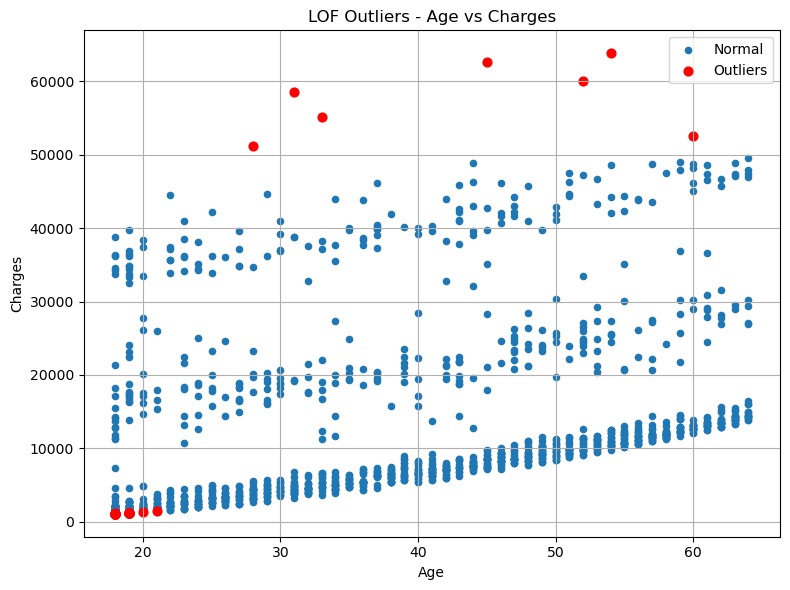

In [7]:
df = pd.read_csv("insurance.csv")

num_cols = df.select_dtypes(include=[np.number]).columns
X = df[num_cols].values

print("Columnas numéricas usadas para LOF:", list(num_cols))

#Instancia y ajuste del modelo LOF
lof = AlgorLOF(n_neighbors=35)
lof.fit(X)

lof_vals = lof.score_samples()
threshold = 1.5
labels = lof.predict(threshold=threshold)

# Imprimir outliers detectados
outlier_idx = np.where(labels == -1)[0]
print("\nÍndices de outliers (LOF >", threshold, "):")
print(outlier_idx)

# Mostrar las filas completas de los outliers
print("\nFilas de outliers:")
print(df.iloc[outlier_idx])


plt.figure(figsize=(8, 6))

# Datos normales
mask_inliers = labels == 1
plt.scatter(df.loc[mask_inliers, "age"],
            df.loc[mask_inliers, "charges"],
            s=20, label="Normal")

# Outliers
plt.scatter(df.loc[outlier_idx, "age"],
            df.loc[outlier_idx, "charges"],
            s=40, label="Outliers", color="red")

plt.xlabel("Age")
plt.ylabel("Charges")
plt.title("LOF Outliers - Age vs Charges")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


Primeros LOF (sklearn, transformados a positivos):
[1.03851866 0.98523413 0.97681957 1.02320774 1.01713869 1.03499246
 1.01553269 0.98063639 0.97652815 1.12107065]

Índices de outliers (sklearn):
[  22   34  136  194  374  385  442  487  513  543  577  584  663  681
  723  781  791  808  819  866  940 1146 1230 1244 1251 1300 1317]

Filas de outliers:
      age     sex     bmi  children smoker     region      charges
22     18    male  34.100         0     no  southeast   1137.01100
34     28    male  36.400         1    yes  southwest  51194.55914
136    19    male  34.100         0     no  southwest   1261.44200
194    18    male  34.430         0     no  southeast   1137.46970
374    20    male  33.330         0     no  southeast   1391.52870
385    19    male  34.400         0     no  southwest   1261.85900
442    18    male  43.010         0     no  southeast   1149.39590
487    19    male  28.700         0     no  southwest   1253.93600
513    19    male  30.400         0     no

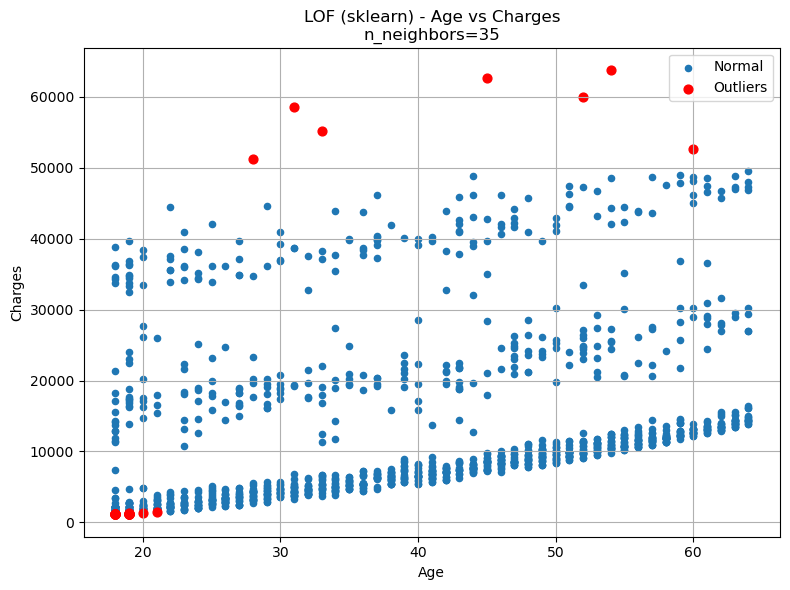

In [8]:

import matplotlib.pyplot as plt
from sklearn.neighbors import LocalOutlierFactor


# 2. LOF con sklearn
n_neighbors = 35  

# 0.02 = 2% de los datos como outliers
contamination = 0.02  

lof = LocalOutlierFactor(
    n_neighbors=n_neighbors,
    contamination=contamination,
    novelty=False  
)

# y_pred: 1 = inlier, -1 = outlier
y_pred = lof.fit_predict(X)

neg_scores = lof.negative_outlier_factor_

lof_scores = -neg_scores  #valores altos  aproximados al outlier 

print("\nPrimeros LOF (sklearn, transformados a positivos):")
print(lof_scores[:10])

# Indices de los outliers según sklearn')
outlier_idx = np.where(y_pred == -1)[0]
print("\nÍndices de outliers (sklearn):")
print(outlier_idx)

print("\nFilas de outliers:")
print(df.iloc[outlier_idx])

plt.figure(figsize=(8, 6))

mask_inliers = labels == 1
mask_outliers = labels == -1

plt.scatter(df.loc[mask_inliers, "age"],
            df.loc[mask_inliers, "charges"],
            s=20, label="Normal")

plt.scatter(df.loc[mask_outliers, "age"],
            df.loc[mask_outliers, "charges"],
            s=40, label="Outliers", color="red")

plt.xlabel("Age")
plt.ylabel("Charges")
plt.title(f"LOF (sklearn) - Age vs Charges\nn_neighbors={n_neighbors}")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


Observaciones: 
En ambos graficos se muestran los mismos resultados, los outliers mas cargados arriba si son detectados y de la misma forma los mas pequeños son detectados. En ambos algoritmos se utilizo un numero de vecinos de 35

<div style="border-left:6px solid #b36b00; border-radius:8px; padding:16px; margin-bottom:16px;">
<h3 style="color:#b36b00; margin-top:0;">2. DBSCAN (Density-Based Spatial Clustering of Applications with Noise) <span style='font-size:0.8em; color:#888;'>&#128201;</span></h3>
<p style="font-size:1.08em;">
<b>DBSCAN</b> es un algoritmo de clustering basado en densidad que agrupa puntos cercanos y considera como outliers (ruido) aquellos que no pertenecen a ningún grupo. A diferencia de K-means, no requiere especificar el número de clusters previamente.
</p>
<ul style="font-size:1.05em;">
<li>Implementa una <b>clase en Python</b> que contenga el algoritmo DBSCAN y agrégala a tu librería.</li>
<li>Prueba tu implementación con el dataset <code>insurance.csv</code> que se encuentra en la carpeta de Data:</li>
  <ul>
    <li>Detecta los outliers usando tu clase.</li>
    <li>Compara los resultados con el modelo DBSCAN de <code>sklearn</code>.</li>
  </ul>
</ul>
<div style="margin-top:10px; background:#fffbe6; border-left:4px solid #b36b00; padding:10px 18px; border-radius:8px;">
<b>Tip:</b> Explica brevemente las diferencias entre los resultados obtenidos por tu clase y los de <code>sklearn</code>.
</div>
</div>

In [ ]:
import numpy as np

class AlgDBSCAN:
    """
    Algoritmo DBSCAN (Density-Based Spatial Clustering of Applications with Noise).

    Parámetros
    ----------
    eps : float
        Radio del vecindario (distancia máxima para ser considerado vecino).
    min_samples : int
        Número mínimo de puntos en el vecindario para formar un cluster.
    """

    def __init__(self, eps=0.5, min_samples=5):
        self.eps = eps
        self.min_samples = min_samples
        self.labels_ = None   # etiquetas finales
        self.X_ = None        # datos

    def _pairwise_distances(self, X):
        """Matriz de distancias euclidianas entre todos los puntos."""
        X = np.asarray(X, dtype=float)

        diff = X[:, np.newaxis, :] - X[np.newaxis, :, :]

        D = np.sqrt(np.sum(diff**2, axis=2))

        return D

    def _region_query(self, D, idx_point):
        """ Devuelve los vecinos de un punto dado.
        """
        return np.where(D[idx_point] <= self.eps)[0]

    def _expand_cluster(self, labels, D, point_idx, neighbors, cluster_id):
        """
        Expande el cluster a partir de un punto nucleo.
        """
        labels[point_idx] = cluster_id
        i = 0
        while i < len(neighbors):
            n_idx = neighbors[i]
            if labels[n_idx] == -1:
                # Se detectó como ruido pero ahora es parte del cluster
                labels[n_idx] = cluster_id
            if labels[n_idx] == 0:
                
                labels[n_idx] = cluster_id
                n_neighbors = self._region_query(D, n_idx)

                if len(n_neighbors) >= self.min_samples:
                    # Agrega nuevos vecinos a la lista
                    neighbors = np.concatenate((neighbors, n_neighbors))
            i += 1

    def fit(self, X):
        """
        Ajusta DBSCAN sobre X y genera etiquetas.

        X: array (n_muestras, n_features)
        """
        X = np.asarray(X, dtype=float)

        self.X_ = X

        n = X.shape[0]

        labels = np.zeros(n, dtype=int)  

        D = self._pairwise_distances(X)

        cluster_id = 0

        for i in range(n):
            if labels[i] != 0:
                # Significa que ya fue visitado
                continue

            neighbors = self._region_query(D, i)

            if len(neighbors) < self.min_samples:
                # Menos de min_samples vecinos => ruido
                labels[i] = -1
            else:
                # Crear nuevo cluster
                cluster_id += 1
                self._expand_cluster(labels, D, i, neighbors, cluster_id)

        self.labels_ = labels
        return self


Columnas numéricas: ['age', 'bmi', 'children', 'charges']

Etiquetas encontradas (cluster_id: cantidad):
-1: 16 puntos
1: 1322 puntos

Puntos de ruido (label = -1): 16


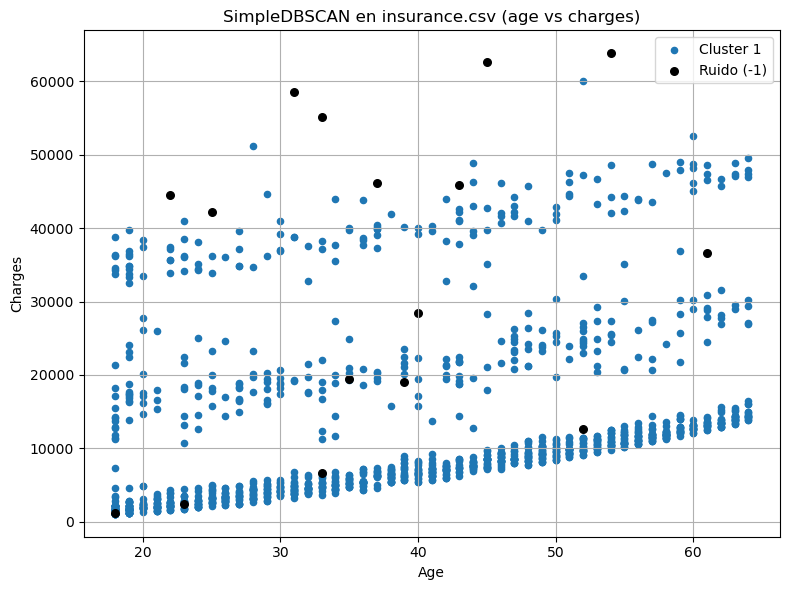

In [30]:
df = pd.read_csv("insurance.csv")

# Usamos solo columnas numéricas
num_cols = df.select_dtypes(include=[np.number]).columns
print("Columnas numéricas:", list(num_cols))

X = df[num_cols].values

# Escalar datos
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

db = AlgDBSCAN(eps=1.20, min_samples=20) 
db.fit(X_scaled)

labels = db.labels_  

unique_labels, counts = np.unique(labels, return_counts=True)
print("\nEtiquetas encontradas (cluster_id: cantidad):")
for lab, cnt in zip(unique_labels, counts):
    print(f"{lab}: {cnt} puntos")

n_noise = np.sum(labels == -1)
print("\nPuntos de ruido (label = -1):", n_noise)


plt.figure(figsize=(8, 6))

# Colores para clusters (ignorando el -1 por ahora)
cluster_ids = [lab for lab in unique_labels if lab != -1]
colors = plt.cm.tab10(np.linspace(0, 1, len(cluster_ids)))

# Puntos de clusters
for lab, col in zip(cluster_ids, colors):
    mask = labels == lab
    plt.scatter(df.loc[mask, "age"],
                df.loc[mask, "charges"],
                s=20,
                label=f"Cluster {lab}",
                c=[col])

# Puntos de ruido
mask_noise = labels == -1
plt.scatter(df.loc[mask_noise, "age"],
            df.loc[mask_noise, "charges"],
            s=30,
            c="black",
            label="Ruido (-1)")

plt.xlabel("Age")
plt.ylabel("Charges")
plt.title("SimpleDBSCAN en insurance.csv (age vs charges)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [31]:
from sklearn.cluster import DBSCAN

Columnas numéricas usadas: ['age', 'bmi', 'children', 'charges']

Etiquetas encontradas (cluster_id: cantidad):
-1: 16 puntos
0: 1322 puntos

Puntos de ruido (label = -1): 16


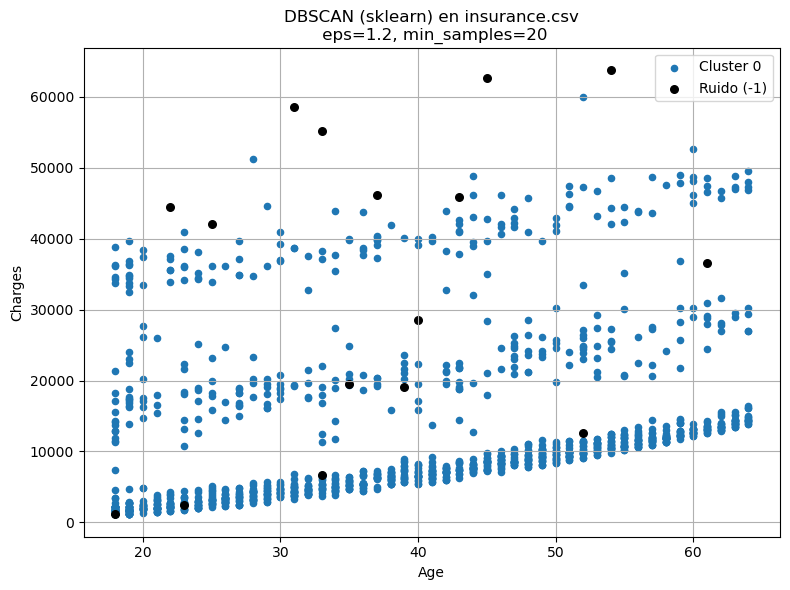

In [35]:


df = pd.read_csv("insurance.csv")

# Solo columnas numéricas
num_cols = df.select_dtypes(include=[np.number]).columns
print("Columnas numéricas usadas:", list(num_cols))

X = df[num_cols].values

#Escalar datos
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


# 3. DBSCAN con sklearn

eps = 1.20          # radio del vecindario en el espacio escalado
min_samples = 20   # mínimo de puntos para ser núcleo

db = DBSCAN(eps=eps, min_samples=min_samples, metric="euclidean")
db.fit(X_scaled)

labels = db.labels_   

unique_labels, counts = np.unique(labels, return_counts=True)
print("\nEtiquetas encontradas (cluster_id: cantidad):")
for lab, cnt in zip(unique_labels, counts):
    print(f"{lab}: {cnt} puntos")

n_noise = np.sum(labels == -1)
print("\nPuntos de ruido (label = -1):", n_noise)


plt.figure(figsize=(8, 6))

cluster_ids = [lab for lab in unique_labels if lab != -1]
colors = plt.cm.tab10(np.linspace(0, 1, len(cluster_ids)))

# Puntos de cada cluster
for lab, col in zip(cluster_ids, colors):
    mask = labels == lab
    plt.scatter(df.loc[mask, "age"],
                df.loc[mask, "charges"],
                s=20,
                c=[col],
                label=f"Cluster {lab}")

# Puntos de ruido
mask_noise = labels == -1
plt.scatter(df.loc[mask_noise, "age"],
            df.loc[mask_noise, "charges"],
            s=30,
            c="black",
            label="Ruido (-1)")

plt.xlabel("Age")
plt.ylabel("Charges")
plt.title(f"DBSCAN (sklearn) en insurance.csv\n eps={eps}, min_samples={min_samples}")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

Observaciones: No hubo realmente diferencia entre el algoritmo y el algoritmo de sklearn. DBSCAN ha sido dificil de ajustar porque es muy sensible al parametro de eps.

Conclusiones: DBSCAN resulto dificil de ajustar en este dataset ya que el dataset no tenia datos agrupables en diferentes clusters ademas que es muy sensible, considero que LOF fue mas adecuado ya que compara un punto vs sus vecinos y devuelve un score continuo y creo que esto ayuda a detectar diferentes densidades.